In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
import os
tf.__version__

'2.11.0'

In [2]:
#Dataset paths
train_path = '/kaggle/input/broken-eggs/train'
test_path = '/kaggle/input/broken-eggs/test'

#Loading TF Datasets
dummy_set, training_dataset = tf.keras.utils.image_dataset_from_directory(
train_path,
labels='inferred',
class_names=['crack', 'empty','good'],
shuffle=True,
batch_size=None,
image_size=(320, 240),
seed=1,
validation_split=0.9,
subset='both',
crop_to_aspect_ratio=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
test_path,
class_names=['crack', 'empty', 'good'],
shuffle=False,
seed=1,
image_size=(320, 240),
batch_size=None,
crop_to_aspect_ratio=False
)
#training_dataset = training_dataset.shuffle(380)
print(training_dataset.element_spec)
print(dummy_set.element_spec)
print(test_dataset.element_spec)

Found 542 files belonging to 3 classes.
Using 55 files for training.
Using 487 files for validation.
Found 27 files belonging to 3 classes.
(TensorSpec(shape=(320, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
(TensorSpec(shape=(320, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
(TensorSpec(shape=(320, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [3]:
X_train = training_dataset.map(lambda x, y: x)
Y_train = training_dataset.map(lambda x, y: y)
#X_val = validation_dataset.map(lambda x, y: x)
#Y_val = validation_dataset.map(lambda x, y: y)
X_test = test_dataset.map(lambda x, y: x)
Y_test = test_dataset.map(lambda x, y: y)
print(X_test.element_spec)

TensorSpec(shape=(320, 240, 3), dtype=tf.float32, name=None)


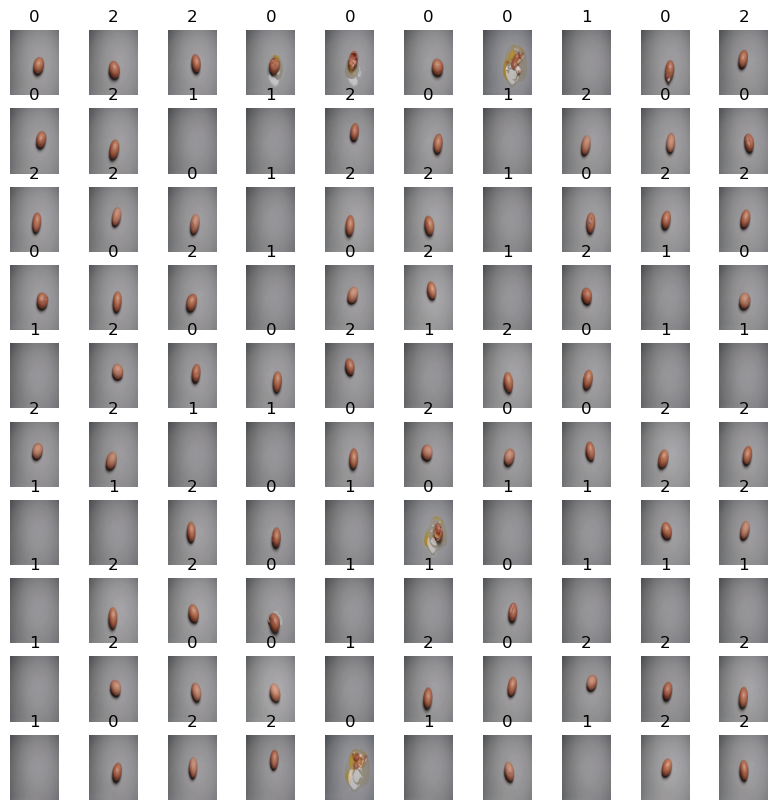

In [4]:
images_iter = iter(X_train)
labels_iter = iter(Y_train)
plt.figure(figsize=(10, 10))
for i in range(100):
    ax = plt.subplot(10, 10, (i + 1))
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

In [5]:
#Normalize images Function
def normalize(image):
    """
    Transform an image into a tensor of shape (Height * Width * 3, )
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
    return image

In [6]:
#Normalize images
new_train = X_train.map(normalize)
#new_val = X_val.map(normalize)
new_test = X_test.map(normalize)
print(next(iter(new_test)))
print(new_test.element_spec)

tf.Tensor([0.30735293 0.30343136 0.325      ... 0.49289215 0.48897058 0.5085784 ], shape=(230400,), dtype=float32)
TensorSpec(shape=(230400,), dtype=tf.float32, name=None)


In [7]:
#One-hot encoding function
def one_hot_matrix(label, depth=3):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """

    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0), shape=[-1, ])
    
    return one_hot

In [8]:
#One Hot Encoding
new_y_train = Y_train.map(one_hot_matrix)
#new_y_val = Y_val.map(one_hot_matrix)
new_y_test = Y_test.map(one_hot_matrix)
print(new_y_train.element_spec)
print(next(iter(new_y_train)))

TensorSpec(shape=(3,), dtype=tf.float32, name=None)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


In [9]:
#Initialize parameters function

def initialize_parameters(n_x=230400, n_h1=24, n_h2=12, n_h3=6, n_y=3):
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [n_h1, n_x]
                        b1 : [n_h1, 1]
                        W2 : [n_h2, n_h1]
                        b2 : [n_h2, 1]
                        W3 : [n_h3, n_h2]
                        b3 : [n_h3, 1]
                        W4 : [n_y, n_h3]
                        b4 : [n_y, 1]
    Argument:
    n_x -- size of the input layer
    n_h1 -- size of the first hidden layer
    n_h2 -- size of second hidden layer
    n_h3 -- size of third hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   

    W1 = tf.Variable(initializer(shape=(n_h1, n_x)))
    b1 = tf.Variable(initializer(shape=(n_h1, 1)))
    W2 = tf.Variable(initializer(shape=(n_h2, n_h1)))
    b2 = tf.Variable(initializer(shape=(n_h2, 1)))
    W3 = tf.Variable(initializer(shape=(n_h3, n_h2)))
    b3 = tf.Variable(initializer(shape=(n_h3, 1)))
    W4 = tf.Variable(initializer(shape=(n_y, n_h3)))
    b4 = tf.Variable(initializer(shape=(n_y, 1)))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}
    
    return parameters

In [10]:
#Initialize parameters
paramaters = initialize_parameters()

In [11]:
#Forward Propagation Function

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)
    A3 = tf.keras.activations.relu(Z3)
    Z4 = tf.math.add(tf.linalg.matmul(W4, A3), b4)
    
    
    return Z4

In [12]:

# Compute Total Loss Function

def compute_total_loss(logits, labels):
    """
    Computes the total loss
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit)
    labels -- "true" labels vector, same shape as Z4
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    
    total_loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(tf.transpose(labels), tf.transpose(logits), from_logits=True))
    
    # YOUR CODE ENDS HERE
    return total_loss

In [13]:
#Build model
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 8, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set
    Y_train -- test set
    X_val -- validation set
    Y_val -- validation set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    # To keep track of the cost
    costs = []                       
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    #Optmizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # Track the accuracy
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # Get the number of elements
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size).prefetch(4)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(4)

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_total_loss = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches:
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z4 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # 2. loss
                minibatch_total_loss = compute_total_loss(Z4, tf.transpose(minibatch_Y))

            # Accumulate the accuracy of all the batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z4))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3, W4, b4]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_total_loss += minibatch_total_loss
        
        # Divide the epoch total loss over the number of samples
        epoch_total_loss /= m
        
         # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_total_loss))
            print("Train accuracy:", train_accuracy.result())
            
            # Evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z4 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z4))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()


    return parameters, costs, train_acc, test_acc

In [14]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100, learning_rate=0.0001)

Cost after epoch 0: 1.264999
Train accuracy: tf.Tensor(0.32032853, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.37037036, shape=(), dtype=float32)
Cost after epoch 10: 1.153731
Train accuracy: tf.Tensor(0.35523614, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.37037036, shape=(), dtype=float32)
Cost after epoch 20: 1.138481
Train accuracy: tf.Tensor(0.35523614, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.37037036, shape=(), dtype=float32)
Cost after epoch 30: 1.127034
Train accuracy: tf.Tensor(0.35523614, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.37037036, shape=(), dtype=float32)
Cost after epoch 40: 1.117817
Train accuracy: tf.Tensor(0.35523614, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.37037036, shape=(), dtype=float32)
Cost after epoch 50: 1.110247
Train accuracy: tf.Tensor(0.35523614, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.37037036, shape=(), dtype=float32)
Cost after epoch 60: 1.104582
Train accuracy: tf.Tensor(0.35523614, sha

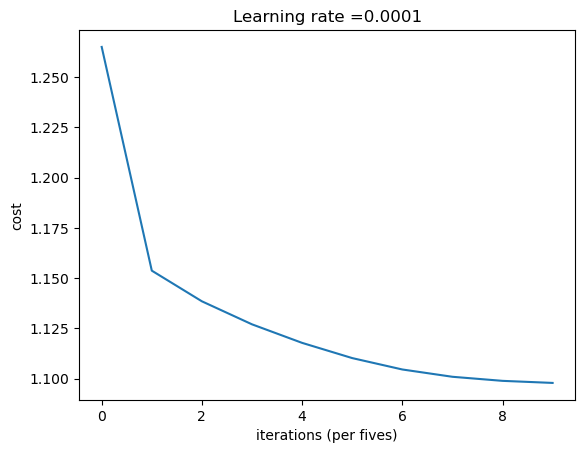

In [15]:
# Plot cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

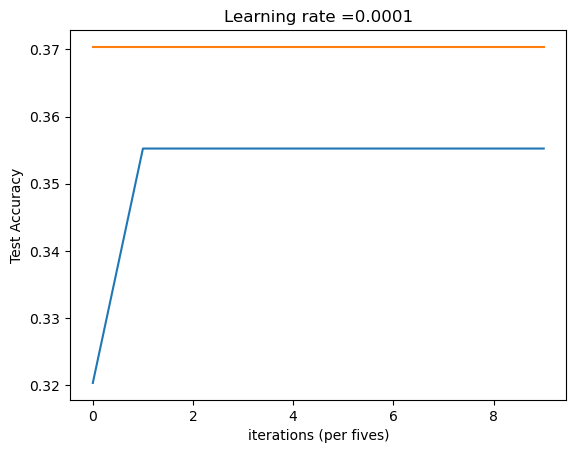

In [16]:
# Plot train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

In [17]:
#Evaluation using test set
class_names = ['crack', 'empty', 'good']
test_dataset = tf.data.Dataset.zip((new_test, Y_test))
for (x_test, y_test) in test_dataset:
    Z4 = forward_propagation(tf.reshape(x_test, (230400,1)), parameters)
    #print(Z4)
    softmax = tf.nn.softmax(tf.transpose(Z4))
    print(softmax)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(softmax)], 100 * np.max(softmax))
    )

tf.Tensor([[0.31707332 0.32297337 0.35995337]], shape=(1, 3), dtype=float32)
This image most likely belongs to good with a 36.00 percent confidence.
tf.Tensor([[0.31707332 0.32297337 0.35995337]], shape=(1, 3), dtype=float32)
This image most likely belongs to good with a 36.00 percent confidence.
tf.Tensor([[0.31707332 0.32297337 0.35995337]], shape=(1, 3), dtype=float32)
This image most likely belongs to good with a 36.00 percent confidence.
tf.Tensor([[0.31707332 0.32297337 0.35995337]], shape=(1, 3), dtype=float32)
This image most likely belongs to good with a 36.00 percent confidence.
tf.Tensor([[0.31707332 0.32297337 0.35995337]], shape=(1, 3), dtype=float32)
This image most likely belongs to good with a 36.00 percent confidence.
tf.Tensor([[0.31707332 0.32297337 0.35995337]], shape=(1, 3), dtype=float32)
This image most likely belongs to good with a 36.00 percent confidence.
tf.Tensor([[0.31707332 0.32297337 0.35995337]], shape=(1, 3), dtype=float32)
This image most likely belong